### Spatial weights and ESDA (Exploratory Spatial Data Analysis) - TX, ACS 2019

ESDA offers direct parallels to many of the aspatial descriptive statistics that are already part of most quantitative research projects: The geographic mean and spatial standard deviation, for example, tell us where the center of our study area is how compact our population is within that area. 

I use ESDA to generalize about our observations and to identify outliers and discontinuities that may disrupt our Score L model or suggest hypotheses about relationships we may wish to explore further as it pertains to health disparities and educational disparities.

This is very pertinent to Score L as we make strict assumptions about distributions - for any thresholding approach it assumes that the data represents no measurement bias and no systematic error. Everything is homogeneous and is treated equally.

ESDA can also be important in confirmatory statistical analysis as spatial autocorrelation can bias outcomes in many spatial and aspatial statistical models. 

Testing for spatial autocorrelation and locating clusters of correlated residuals will be important in explaining why certain scores are associated together.


For example, in section 6, I use LISA's to identify geographical clusters of values or find geographcial outliers. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work - namely median income. I will be extending this to educational attainment and job opportunities in a given radius - indicating economic mobility.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
from scipy.stats import stats

np.random.seed(0)
print(gpd.__version__, ps.__version__)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


0.9.0 2.3.0


## Load the tracts data set

In [2]:
# load geojson, display shape
tracts = gpd.read_file('census/census_tracts_data.geojson')
tracts = tracts.set_index('index')
tracts.shape

(5265, 38)

In [3]:
# what variables are present?
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'total_pop',
       'median_age', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_asian',
       'pct_male', 'pct_single_family_home', 'med_home_value',
       'med_rooms_per_home', 'pct_built_before_1940', 'pct_renting',
       'rental_vacancy_rate', 'avg_renter_household_size', 'med_gross_rent',
       'med_household_income', 'mean_commute_time', 'pct_commute_drive_alone',
       'pct_below_poverty', 'pct_college_grad_student',
       'pct_same_residence_year_ago', 'pct_bachelors_degree',
       'pct_english_only', 'pct_foreign_born', 'state', 'county', 'geometry'],
      dtype='object')

In [4]:
# inspect the first 5 rows
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,...,pct_commute_drive_alone,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,geometry
index,,,,,,,,,,,,,,,,,,,,,
48001950100,48,001,950100,9501,Census Tract 9501,G5020,S,483306619,7864313,+31.9714680,...,84.0,16.3,30.6,4775.0,91.2,4495.0,0.4,48,001,"MULTIPOLYGON (((-95.69702 31.97597, -95.69699 ..."
48001950401,48,001,950401,9504.01,Census Tract 9504.01,G5020,S,16549991,296734,+31.7346372,...,100.0,0.0,34.2,4838.0,75.2,4800.0,1.6,48,001,"MULTIPOLYGON (((-95.84791 31.75753, -95.84806 ..."
48001950402,48,001,950402,9504.02,Census Tract 9504.02,G5020,S,72472039,2627857,+31.8000515,...,100.0,21.5,33.8,7506.0,69.7,7501.0,1.0,48,001,"MULTIPOLYGON (((-95.98357 31.78925, -95.98354 ..."
48001950500,48,001,950500,9505,Census Tract 9505,G5020,S,23132052,99223,+31.7878850,...,85.1,19.4,28.2,4423.0,84.0,4178.0,0.7,48,001,"MULTIPOLYGON (((-95.68769 31.81041, -95.68741 ..."
48001950600,48,001,950600,9506,Census Tract 9506,G5020,S,20653883,329641,+31.7502049,...,79.9,17.4,39.3,5109.0,71.2,4890.0,0.0,48,001,"MULTIPOLYGON (((-95.70774 31.72559, -95.70765 ..."


In [5]:
score_l_df = pd.read_csv("merged_df_score_l_2794.csv", dtype={
    "FIPS_tract_id": str
})

score_l_df.set_index("FIPS_tract_id", inplace=True)

In [6]:
census_acs_2019 = pd.read_csv("../../../data_pipeline/data/dataset/census_acs_2019/usa.csv")

In [8]:
# calculate pop density in persons per sq km
tracts['pop_density'] = tracts['total_pop'] / (tracts['ALAND'] / 1e6)
tracts = tracts.replace([np.inf, -np.inf], np.nan)
tracts = tracts.dropna(subset=['pop_density'])

# project spatial geometries from lat-long to a meter-based projection
utm_tx = '+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
tracts = tracts.to_crs(utm_tx)

In [9]:
df_merged = score_l_df.merge(tracts, how='inner', left_index=True, right_index=True)

In [10]:
df_merged.shape

(104, 75)

In [11]:
tracts = tracts[tracts.index.isin(df_merged.index.values)]

## 1. Exploratory analysis

Let's see what we've got with a couple key variables of interest.

In [12]:
# descriptive stats
tracts['pop_density'].describe()

count      104.000000
mean      2607.677071
std       2474.100685
min         36.175061
25%        997.242613
50%       2072.942692
75%       3287.516789
max      15581.109178
Name: pop_density, dtype: float64

In [13]:
# descriptive stats
tracts['med_household_income'].describe()

count      103.000000
mean     34038.737864
std       8177.985053
min      11912.000000
25%      28953.000000
50%      35990.000000
75%      39517.000000
max      53516.000000
Name: med_household_income, dtype: float64

In [14]:
# create a function to choropleth map a df column
def map_variable(df, col, scheme='quantiles', k=10, cmap='plasma', figsize=(10,10)):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme=scheme, k=k, cmap=cmap, figsize=figsize, legend = True)
    ax.axis('off')
    plt.show()

In [47]:
tracts.index.isin(tracts[tracts['med_household_income'] < 20000].index)

array([False, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

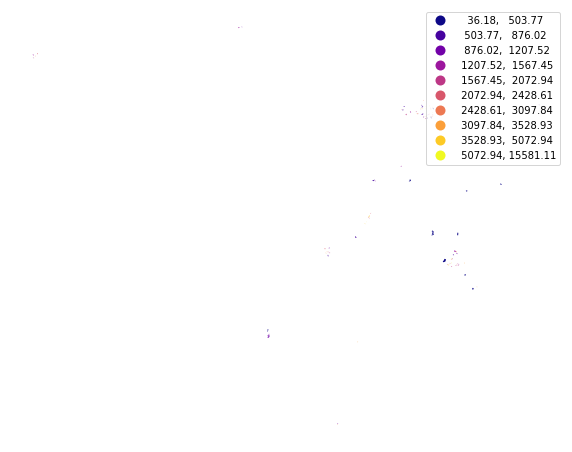

In [15]:
# map a variable
map_variable(c, 'pop_density')

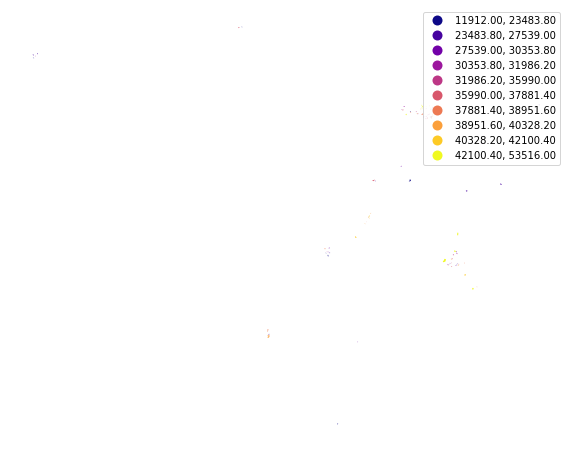

In [16]:
# map another variable
map_variable(tracts, 'med_household_income')

It looks like these two variables might be negatively correlated?

In [17]:
# calculate the correlation coefficient and its p-value
x = tracts.dropna(subset=['pop_density', 'med_household_income'])['pop_density']
y = tracts.dropna(subset=['pop_density', 'med_household_income'])['med_household_income']
r, p = stats.pearsonr(x=x, y=y)
print('r={:.4f}, p={:.4f}'.format(r, p))

r=0.1018, p=0.3061


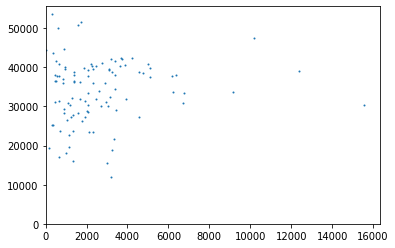

In [18]:
# scatter plot them with matplotlib
fig, ax = plt.subplots()
ax.scatter(x=x, y=y, s=1)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.show()

In [19]:
# estimate a simple linear regression model with scipy
m, b, r, p, se = stats.linregress(x=x, y=y)
print('m={:.4f}, b={:.4f}, r^2={:.4f}, p={:.4f}'.format(m, b, r ** 2, p))

m=0.3366, b=33152.6311, r^2=0.0104, p=0.3061


In [20]:
# estimate a log-log simple linear regression model with scipy
m, b, r, p, se = stats.linregress(x=np.log(x), y=np.log(y))
print('m={:.4f}, b={:.4f}, r^2={:.4f}, p={:.4f}'.format(m, b, r ** 2, p))

m=0.0172, b=10.2724, r^2=0.0035, p=0.5508


/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


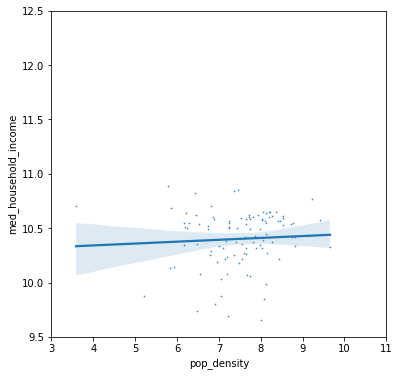

In [21]:
# plot the log-log regression line with 95% CI using seaborn
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(np.log(x), np.log(y), marker='.', scatter_kws={'s':2}, ax=ax)
ax.set_xlim((3, 11))
ax.set_ylim((9.5, 12.5))
plt.show()

## 2. Spatial weights matrix

Spatial weights define the spatial connections among our units of analysis (tracts in this case).

### 2.1. Contiguity-based weights: rook contiguity

Using rook contiguity, two spatial units must share an edge of their boundaries to be considered neighbors. This isn't terribly common in practice (since queen is usually more useful, but it's worth understanding).

In [48]:
# get the tract labels (GEOIDs) and pick one to work with later
# tracts_subset = tracts[tracts.index.isin(df_merged.index.values)]
labels = tracts.index.tolist()
label = labels[5]

In [49]:
%%time

from libpysal.weights.contiguity import Queen, Rook
from libpysal.weights import KNN, min_threshold_distance
from libpysal.weights import DistanceBand, lag_spatial
# calculate rook spatial weights
w_rook = Rook.from_dataframe(tracts, ids=labels, id_order=labels)

CPU times: user 93.6 ms, sys: 6.18 ms, total: 99.8 ms
Wall time: 98.3 ms


/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 91 disconnected components.
 There are 81 islands with ids: 48027023202, 48027023500, 48029110800, 48029130600, 48029150800, 48029160501, 48029170101, 48029180702, 48029191304, 48037010500, 48061013401, 48061013802, 48113003700, 48113006002, 48113007201, 48113007821, 48113007823, 48113007827, 48113008900, 48113009000, 48113009202, 48113009610, 48113010703, 48113010903, 48113011104, 48113011300, 4

### 2.2. Contiguity-based weights: queen contiguity

Using queen contiguity, two spatial units need only share a vertex (a single point) of their boundaries to be considered neighbors.

In [50]:
%%time
# calculate queen spatial weights
w_queen = Queen.from_dataframe(tracts, ids=labels, id_order=labels)

CPU times: user 76.1 ms, sys: 4.81 ms, total: 80.9 ms
Wall time: 79.4 ms


/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 87 disconnected components.
 There are 75 islands with ids: 48027023202, 48027023500, 48029110800, 48029130600, 48029150800, 48029160501, 48029170101, 48029180702, 48029191304, 48037010500, 48061013401, 48061013802, 48113003700, 48113006002, 48113007201, 48113007823, 48113007827, 48113008900, 48113009000, 48113009202, 48113009610, 48113010703, 48113010903, 48113011104, 48113011300, 48113012210, 48113014103, 48113014308, 48113014407, 48113018141, 48113019034, 48121021739, 48141000301, 48141001001, 48141001115, 48145000400, 48167724200, 48167725900, 48185180400, 48201233103, 48201240100, 48201310800, 48201311800, 48201312200, 48201312800, 48201313800, 48201341201, 48201420500, 48201421201, 48201432002, 48201432901, 48201454400, 48201534001, 48209010302, 48225950400, 48303000202, 48303001702, 483090

In [51]:
# find the neighbors of some tract
w_queen.neighbors[label]

[]

In [52]:
# this is a raw contiguity matrix, so weights are binary 1s and 0s meaning neighbor/not
w_queen.weights[label]

[]

In [53]:
# how many neighbors does this tract have?
w_queen.cardinalities[label]

0

In [54]:
# convert cardinalities to series and describe data -- looks right-skewed
cardinalites_queen = pd.Series(w_queen.cardinalities)
cardinalites_queen.describe()

count    104.000000
mean       0.326923
std        0.565038
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000
dtype: float64

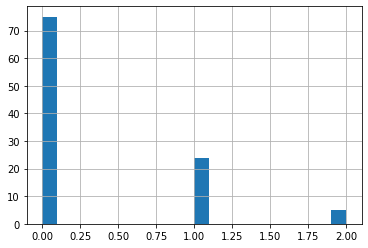

In [55]:
# look at the distribution of number of neighbors
ax = cardinalites_queen.hist(bins=20)

In [56]:
# number of observations
w_queen.n

104

In [57]:
# average number of neighbors
w_queen.mean_neighbors

0.3269230769230769

In [58]:
# min number of neighbors
w_queen.min_neighbors

0

In [59]:
# max number of neighbors
w_queen.max_neighbors

2

In [60]:
# islands are observations with no neighbors, disconnected 
# in space (can cause modeling problems)
len(w_queen.islands)

75

##### Plot a census tract of interest, along with its neighbors:

In [62]:
# fig, ax = plt.subplots(figsize=(6, 6))
# tracts.plot(ax=ax, facecolor='#999999', edgecolor='w', linewidth=0.5)

# # plot some tract of interest in red
# tract = tracts.loc[[label]]
# tract.plot(ax=ax, facecolor='r', edgecolor='w', linewidth=1)

# # plot the neighbors in blue
# neighbors = tracts.loc[w_queen[label]]
# neighbors.plot(ax=ax, facecolor='b', edgecolor='w', linewidth=1)

# # zoom to area of interest
# xmin, ymin, xmax, ymax = neighbors.unary_union.bounds
# ax.axis('equal')
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# ax.set_title('Neighbors of tract {}'.format(label))
# plt.show()

### 3.3. Distance-based weights: *k*-nn

Find the *k*-nearest neighbors of each tract

In [63]:
%%time
# k-nearest neighbors finds the closest k tract centroids to each tract centroid
w_knn = KNN.from_dataframe(tracts, k=6)

CPU times: user 17.6 ms, sys: 2.24 ms, total: 19.8 ms
Wall time: 19 ms


/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [64]:
# they all have exactly k neighbors
w_knn.neighbors[label]

['48029170101',
 '48029110800',
 '48029150800',
 '48029130600',
 '48029180702',
 '48029191304']

### 3.4. Distance-based weights: distance band

Here tracts are considered neighbors of some tract if they are within a given threshold distance of it. Distance band weights can be specified to take on continuous values rather than binary (1s and 0s), with these values being the inverse distance between each pair of "neighboring" units. The default (linear) distance-decay exponent is thus -1. If we set it to -2, we get gravity model weights.

In [65]:
# first determine the minimum nearest neighbor distance so each unit is assured of at least one neighbor
x = tracts.centroid.x
y = tracts.centroid.y
coords = np.array([x, y]).T
threshold = min_threshold_distance(coords)
threshold

210475.92289934136

In [66]:
%%time
# default alpha=-1 and gravity weights alpha=-2
w_dist = DistanceBand.from_dataframe(tracts, threshold=threshold, binary=False, alpha=-1)

CPU times: user 26.4 ms, sys: 2.9 ms, total: 29.3 ms
Wall time: 27.9 ms


/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [67]:
# how many distance-band neighbors does our tract have?
len(w_dist.neighbors[label])

15

##### Map the neighbors, colored by weight from nearest to furthest:

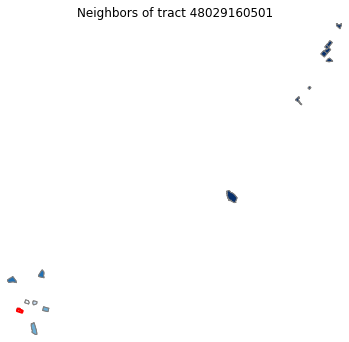

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))
tracts.plot(ax=ax, facecolor='k', edgecolor='gray', linewidth=1)

# get the tract of interest and its neighbors/weights
tract = tracts.loc[[label]]
weights = pd.Series(w_dist[label])
neighbors = tracts.loc[weights.index, ['geometry']]

# plot the tract's neighbors in blues by weight
neighbors['weights_scaled'] = weights
neighbors.plot(ax=ax, column='weights_scaled', cmap='Blues_r', edgecolor='gray', linewidth=1, scheme='Fisher_Jenks')

# plot the tract of interest in white
tract.plot(ax=ax, facecolor='w', edgecolor='r', linewidth=2)

# zoom to area of interest
xmin, ymin, xmax, ymax = neighbors.unary_union.bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')

ax.set_title('Neighbors of tract {}'.format(label))
plt.show()

### 3.5. Standardizing weights

A spatial weights matrix with raw values (e.g., binary 1s and 0s for neighbor/not) is not always the best for analysis. Some sort of standardization is useful.

In [69]:
# inspect the neighbors and weights of our tract
w_queen[label]

{}

In [70]:
# check the current transformation of the weights matrix (O = original)
w_queen.get_transform()

'O'

Typically, we want to apply a row-based transformation, so every row of the matrix sums up to 1.

In [71]:
# transform the queen weights
w_queen.set_transform('R')
w_queen[label]

('WARNING: ', '48027023202', ' is an island (no neighbors)')
('WARNING: ', '48027023500', ' is an island (no neighbors)')
('WARNING: ', '48029110800', ' is an island (no neighbors)')
('WARNING: ', '48029130600', ' is an island (no neighbors)')
('WARNING: ', '48029150800', ' is an island (no neighbors)')
('WARNING: ', '48029160501', ' is an island (no neighbors)')
('WARNING: ', '48029170101', ' is an island (no neighbors)')
('WARNING: ', '48029180702', ' is an island (no neighbors)')
('WARNING: ', '48029191304', ' is an island (no neighbors)')
('WARNING: ', '48037010500', ' is an island (no neighbors)')
('WARNING: ', '48061013401', ' is an island (no neighbors)')
('WARNING: ', '48061013802', ' is an island (no neighbors)')
('WARNING: ', '48113003700', ' is an island (no neighbors)')
('WARNING: ', '48113006002', ' is an island (no neighbors)')
('WARNING: ', '48113007201', ' is an island (no neighbors)')
('WARNING: ', '48113007823', ' is an island (no neighbors)')
('WARNING: ', '481130078

{}

In [72]:
# transform the linear-decay distance-based weights
w_dist.set_transform('R')
w_dist[label]

{'48029110800': 0.18978185729300112,
 '48029130600': 0.12319529619318503,
 '48029150800': 0.1370487572692595,
 '48029170101': 0.28791347498098213,
 '48029180702': 0.10515753230504479,
 '48029191304': 0.07700863495815723,
 '48209010302': 0.01353957165348076,
 '48453001804': 0.008184678306329738,
 '48453001806': 0.008087552480183932,
 '48453001811': 0.008186327368227162,
 '48453001819': 0.008052183129697358,
 '48453001822': 0.007973296124783142,
 '48453001863': 0.007616550406552777,
 '48453002315': 0.00891808387476705,
 '48453002419': 0.0093362036563483}

PySAL supports the following transformations:

  - O: original, returning the object to the initial state
  - B: binary, with every neighbor having assigned a weight of 1
  - R: row-based, with all the neighbors of a given observation adding up to 1
  - V: variance stabilizing, with the sum of all the weights being constrained to the number of observations

**It can take a long time to calculate a weights matrix for a large data set.**

Once you've created yours, you might want to save it to disk to re-use in subsequent analyses.

In [73]:
# save your matrix to disk
import libpysal
f = libpysal.io.open('tracts_queen.gal', 'w')
f.write(w_queen)
f.close()

In [74]:
# read a matrix from disk (notice its transformation)
w_queen = libpysal.io.open('tracts_queen.gal', 'r').read()
w_queen[label]

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 87 disconnected components.
 There are 75 islands with ids: 48027023202, 48027023500, 48029110800, 48029130600, 48029150800, 48029160501, 48029170101, 48029180702, 48029191304, 48037010500, 48061013401, 48061013802, 48113003700, 48113006002, 48113007201, 48113007823, 48113007827, 48113008900, 48113009000, 48113009202, 48113009610, 48113010703, 48113010903, 48113011104, 48113011300, 48113012210, 48113014103, 48113014308, 48113014407, 48113018141, 48113019034, 48121021739, 48141000301, 48141001001, 48141001115, 48145000400, 48167724200, 48167725900, 48185180400, 48201233103, 48201240100, 48201310800, 48201311800, 48201312200, 48201312800, 48201313800, 48201341201, 48201420500, 48201421201, 48201432002, 48201432901, 48201454400, 48201534001, 48209010302, 48225950400, 48303000202, 48303001702, 483090

{}

## 4. Spatial lag

Spatial lag tells us about values near some spatial unit. Calculate spatial lag of the `med_household_income` variable. If the spatial weights matrix is row-standardized, then the spatial lag is the average value of an observation's neighbors.

In [75]:
# pick a variable to investigate
col = 'med_household_income'

In [76]:
# first drop null rows
tracts_not_null = tracts[[col, 'geometry']].dropna()
y = tracts_not_null[col]

In [77]:
# recompute spatial weights for these observations then row-standardize
w_queen = Queen.from_dataframe(tracts_not_null)
w_queen.set_transform('R')

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING:

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 86 disconnected components.
 There are 74 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 34, 35, 36, 37, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 66, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 89, 90, 93, 96, 97, 98, 99, 100.
  warnings.warn(message)


In [78]:
# compute spatial lag
y_lag = lag_spatial(w_queen, y)

In [79]:
col_lag = '{}_lag'.format(col)
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag}).astype(int)
data_lag.sample(10)

,med_household_income,med_household_income_lag
index,,
48113010903,30313,0
48201432002,33478,0
48029110800,28378,0
48201240100,30945,0
48201550301,30236,50941
48303001702,36569,0
48113007819,32478,30445
48201454400,44526,0
48201313800,28885,0


## 6. Spatial autocorrelation

Statistical models typically assume that the observations are independent of each other. This assumption is violated when a variable's value at one location is correlated with its value at nearby locations. This is called spatial autocorrelation, and is common in the real world due to proximity-based spillover effects. Substantive spatial autocorrelation can be explained by social or economic theory that describes a spatial relationship. Nuisance spatial autocorrelation stems from data problems.

*Positive spatial autocorrelation*: nearby values tend to be more similar (e.g. income, home values, temperature, rainfall)

*Negative spatial autocorrelation*: nearby values tend to be more dissimilar (e.g. fire stations, grocery stores)

### 6.1. Moran's I

Moran's I measures *global* spatial autocorrelation: do values tend to be near other (dis)similar values. Values > 1 indicate positive spatial autocorrelation, and values < 1 indicate negative spatial autocorrelation.

In [80]:
# calculate the statistic
from esda.moran import Moran
mi = Moran(data_lag[col], w_queen)

In [81]:
# show the I value
mi.I

0.3657174069181714

In [82]:
# statistical inference: show the p value
mi.p_sim

0.047

If we generated a large number of maps with the same values but randomly allocated over space, and calculated Moran's I for each of these maps, only 0.05% of them would display a larger absolute value than the one we computed from the real-world data set. Thus there is a 0.05% chance of getting the observed value of Moran's I if the spatial distribution of our variable is random. We can conclude that the variable's distribution is statistically-significantly postively spatially autocorrelated. We'll talk more about inference in the other notebook

### 6.2. Moran plots

A Moran plot scatter plots the spatially-lagged values (y-axis) vs the original variable's values (x-axis). Moran's I equals the slope of the line in a Moran plot, which makes this all a bit easier to conceptualize.

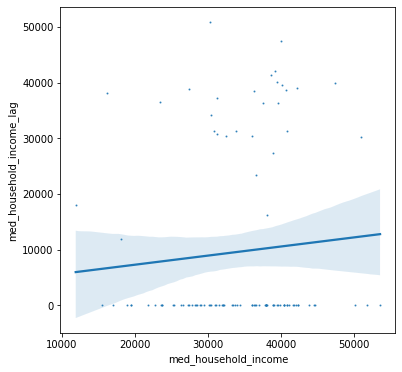

In [83]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=col, y=col_lag, data=data_lag, scatter_kws={'s':1})
plt.show()

In [84]:
# standardize the vector (i.e., calculate z-scores)
y_std = (y - y.mean()) / y.std()

In [85]:
# compute the spatial lag of the standardized vector and save it as a series with same index
y_std_lag = pd.Series(lag_spatial(w_queen, y_std), index=y_std.index, name=col_lag)

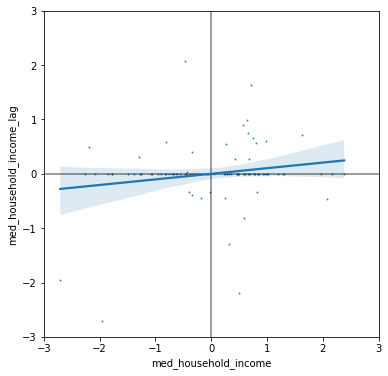

In [86]:
# standardized moran's plot, ignoring outliers beyond 3 std devs
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
sns.regplot(ax=ax, x=y_std, y=y_std_lag, scatter_kws={'s':1})
plt.show()

Notice the 95% confidence interval shading and the positive slope. Given the value of Moran's I that we calculated earlier (and its p-value), we can conclude that the slope of the line is statistically-significantly different from zero. This plot makes it visually apparent.

In [87]:
# estimate a simple linear regression model (of the line above)
m, b, r, p, se = stats.linregress(x=y_std, y=y_std_lag)
print('m={:.4f}, b={:.4f}, r^2={:.4f}, p={:.4f}'.format(m, b, r ** 2, p))

m=0.1030, b=0.0006, r^2=0.0343, p=0.0611


In [88]:
# the slope is the same as moran's I, calculated earlier
mi.I

0.3657174069181714

### 6.3. LISAs

Local Indicators of Spatial Autocorrelation: are there specific areas with high concentrations of (dis)similar values?

Moran's I tells us about spatial clustering across the data set as a whole. However, it does not tell us where these clusters occur. For that, we need a local measure. Essentially, we will classify the data set's observations into four groups based on the four quadrants of the Moran plot:

  1. **HH**: high value near other high values (*hot spots*)
  1. **LL**: low value near other low values (*cold spots*)
  1. **HL**: high value near low values (*spatial outliers*)
  1. **LH**: low value near high values (*spatial outliers*)

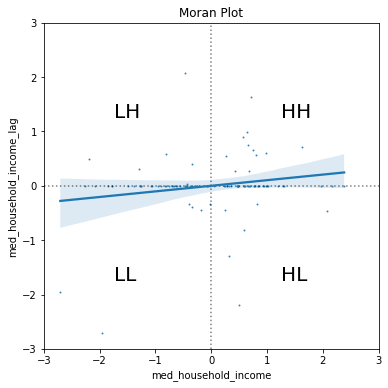

In [89]:
# standardized moran's plot again, from subsection above
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axvline(0, c='k', ls=':', alpha=0.5)
ax.axhline(0, c='k', ls=':', alpha=0.5)
ax.text(1.25, 1.25, 'HH', fontsize=20)
ax.text(1.25, -1.75, 'HL', fontsize=20)
ax.text(-1.75, 1.25, 'LH', fontsize=20)
ax.text(-1.75, -1.75, 'LL', fontsize=20)
ax.set_title('Moran Plot')
sns.regplot(ax=ax, x=y_std, y=y_std_lag, scatter_kws={'s':1})
plt.show()